In [3]:
# import gerrychain graph function
from gerrychain import Graph

# read the .json file from laptop files
filepath = 'C:\\Users\\colle\\Downloads\\'
filename = 'NM_county.json'

# read the graph from the .json file
G = Graph.from_json( filepath + filename )

In [4]:
# assign the population for each county as the name TOTPOP (total population)
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [5]:
# Use a 1% population deviation between districts (+/- 0.5%)
deviation = 0.01

import math

# number of districts in NM
k = 3

# total state population is the sum of TOTPOP for all nodes
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

# upper and lower bounds are set
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 702312 and U = 709369 and k = 3


In [6]:
# import gurobi and the GRB function
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-18


In [7]:
# objective is to minimize weighted cut edges (district perimeter lengths)
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim'] * y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [8]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [9]:
# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

r[26,0].LB = 1  # fix Dona Ana (Las Cruces) county as root of district 0
r[13,1].LB = 1 # fix Bernalillo (Alburquerque) county as root of district 1

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

# import networkx function
import networkx as nx

# directed version of G
DG = nx.DiGraph(G)

#add flow variables to model
f = m.addVars( DG.edges )

In [10]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

# update the model
m.update()

In [11]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0x09c9ec15
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [4e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 139 rows and 112 columns
Presolve time: 0.01s
Presolved: 347 rows, 320 columns, 1431 nonzeros
Variable types: 150 continuous, 170 integer (170 binary)

Root relaxation: objective 5.542803e+00, 290 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.54280    0   59          -    5.54280    

In [12]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 13.39744446868476
District 0 has population 707695 and contains counties ['Roosevelt', 'Lincoln', 'Torrance', 'Luna', 'Lea', 'Chaves', 'Sierra', 'Valencia', 'De Baca', 'Otero', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

District 1 has population 707195 and contains counties ['Bernalillo', 'Catron', 'Cibola']

District 2 has population 702632 and contains counties ['Curry', 'San Juan', 'Guadalupe', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Quay', 'Union', 'San Miguel', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']



In [13]:
# import geopandas function
import geopandas as gpd

In [15]:
# Read New Mexico county shapefile from "NM_county.shp"
filepath = 'C:\\Users\\colle\\Downloads\\'
filename = 'NM_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

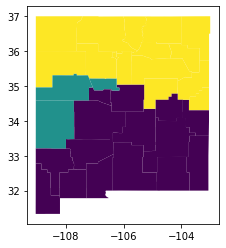

In [16]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

# plot the dataframe
my_fig = df.plot(column='assignment').get_figure()